In [21]:
import pickle
import torch
import os
import numpy as np
import json
import pandas as pd
import math

In [10]:
index2tag = pickle.load(open('data/index_to_tag.pickle', 'rb'))

In [11]:
index2tag

{0: '.',
 1: 'ADJ',
 2: 'ADP',
 3: 'ADV',
 4: 'CONJ',
 5: 'DET',
 6: 'NOUN',
 7: 'NUM',
 8: 'PRON',
 9: 'PRT',
 10: 'VERB',
 11: 'X'}

In [34]:
ffnn_run_dir = 'part1/runs/FINAL_epochs=8,batch_size=1024,hidden_dim=[1024, 512, 512],timestamp=2023-03-10_01-25-08'
enc_only_run_dir = 'part2/runs/enc_only,epochs=5,batch_size=128,hidden_dim=128,timestamp=2023-03-10_01-27-26/'
enc_dec_run_dir = 'part2/runs/epochs=5,batch_size=128,hidden_dim=128,timestamp=2023-03-09_21-31-24/'

In [42]:
def get_eval_score(run_dir):
    precision = 0
    recall = 0
    fpoint5 = 0
    f1 = 0
    f2 = 0
    tagwise_precision = torch.zeros(12)
    tagwise_recall = torch.zeros(12)
    tagwise_fpoint5 = torch.zeros(12)
    tagwise_f1 = torch.zeros(12)
    tagwise_f2 = torch.zeros(12)
    for eval_file in os.listdir(f'{run_dir}/eval'):
        data = json.load(open(f'{run_dir}/eval/{eval_file}', 'r'))
        precision += data['precision']
        recall  += data['recall']
        fpoint5 += data['f0.5']
        f1 += data['f1']
        f2 += data['f2']
        tagwise_precision += torch.tensor(data['tag_wise']['precision'])
        tagwise_recall  += torch.tensor(data['tag_wise']['recall'])
        tagwise_fpoint5 += torch.tensor(data['tag_wise']['f0.5'])
        tagwise_f1 += torch.tensor(data['tag_wise']['f1'])
        tagwise_f2 += torch.tensor(data['tag_wise']['f2'])

    metrics = pd.DataFrame(index=list(index2tag.values()), columns=['precision', 'recall', 'f1'])

    metrics['precision'] = (tagwise_precision / 5).tolist()
    metrics['recall'] = (tagwise_recall / 5).tolist()
    # metrics['f0.5'] = (tagwise_fpoint5 / 5).tolist()
    metrics['f1'] = (tagwise_f1 / 5).tolist()
    # metrics['f2'] = (tagwise_f2 / 5).tolist()
            
    print({
        'precision': round(precision/5, 4),
        'recall': round(recall / 5, 4),
        'f0.5': round(fpoint5 / 5, 4),
        'f1': round(f1 / 5, 4),
        'f2': round(f2 / 5, 4),
    })
    display(metrics.round(4))


In [43]:
get_eval_score(ffnn_run_dir)

{'precision': 0.9702, 'recall': 0.9702, 'f0.5': 0.9702, 'f1': 0.9702, 'f2': 0.9702}


,precision,recall,f1
.,0.9997,0.9999,0.9998
ADJ,0.9134,0.9074,0.9104
ADP,0.9780,0.9814,0.9797
ADV,0.9258,0.9399,0.9327
CONJ,0.9937,0.9896,0.9916
DET,0.9925,0.9936,0.9931
NOUN,0.9627,0.9658,0.9642
NUM,0.9755,0.8393,0.9022
PRON,0.9894,0.9860,0.9877
PRT,0.9451,0.9367,0.9408


In [44]:
get_eval_score(enc_only_run_dir)

{'precision': 0.9762, 'recall': 0.9762, 'f0.5': 0.9762, 'f1': 0.9762, 'f2': 0.9762}


,precision,recall,f1
.,0.9998,0.9999,0.9998
ADJ,0.9417,0.9437,0.9427
ADP,0.9591,0.9725,0.9658
ADV,0.9421,0.9256,0.9338
CONJ,0.9955,0.9950,0.9953
DET,0.9923,0.9941,0.9932
NOUN,0.9818,0.9807,0.9813
NUM,0.9774,0.9679,0.9726
PRON,0.9945,0.9682,0.9812
PRT,0.8886,0.8734,0.8809


In [45]:
get_eval_score(enc_dec_run_dir)

{'precision': 0.9832, 'recall': 0.9832, 'f0.5': 0.9832, 'f1': 0.9832, 'f2': 0.9832}


,precision,recall,f1
.,0.9991,0.9997,0.9994
ADJ,0.9501,0.9478,0.9489
ADP,0.9850,0.9938,0.9894
ADV,0.9683,0.9519,0.9600
CONJ,0.9963,0.9954,0.9959
DET,0.9956,0.9967,0.9961
NOUN,0.9818,0.9806,0.9812
NUM,0.9861,0.9182,0.9509
PRON,0.9909,0.9846,0.9877
PRT,0.9742,0.9577,0.9658


In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

In [114]:
def plot_confusion_matrix(run_dir, model):
    conf_matrix = pd.read_csv(f'{run_dir}/confusion_matrix.csv', index_col=0)
    matrix = conf_matrix.to_numpy()
    percent_values = pd.DataFrame((matrix / matrix.sum(axis=1).reshape(-1,1)) * 100, index=conf_matrix.index, columns=conf_matrix.columns).round(4)
    plt.figure(figsize=(16, 12))
    fig = sns.heatmap(percent_values, annot=True, fmt='.04f', cmap=sns.color_palette(
        "viridis", as_cmap=True))
    fig.set(xlabel='Predicted Label', ylabel='True Label')
    fig.set_title(f"Confusion Matrix for {model} (in % values)", fontsize=16)

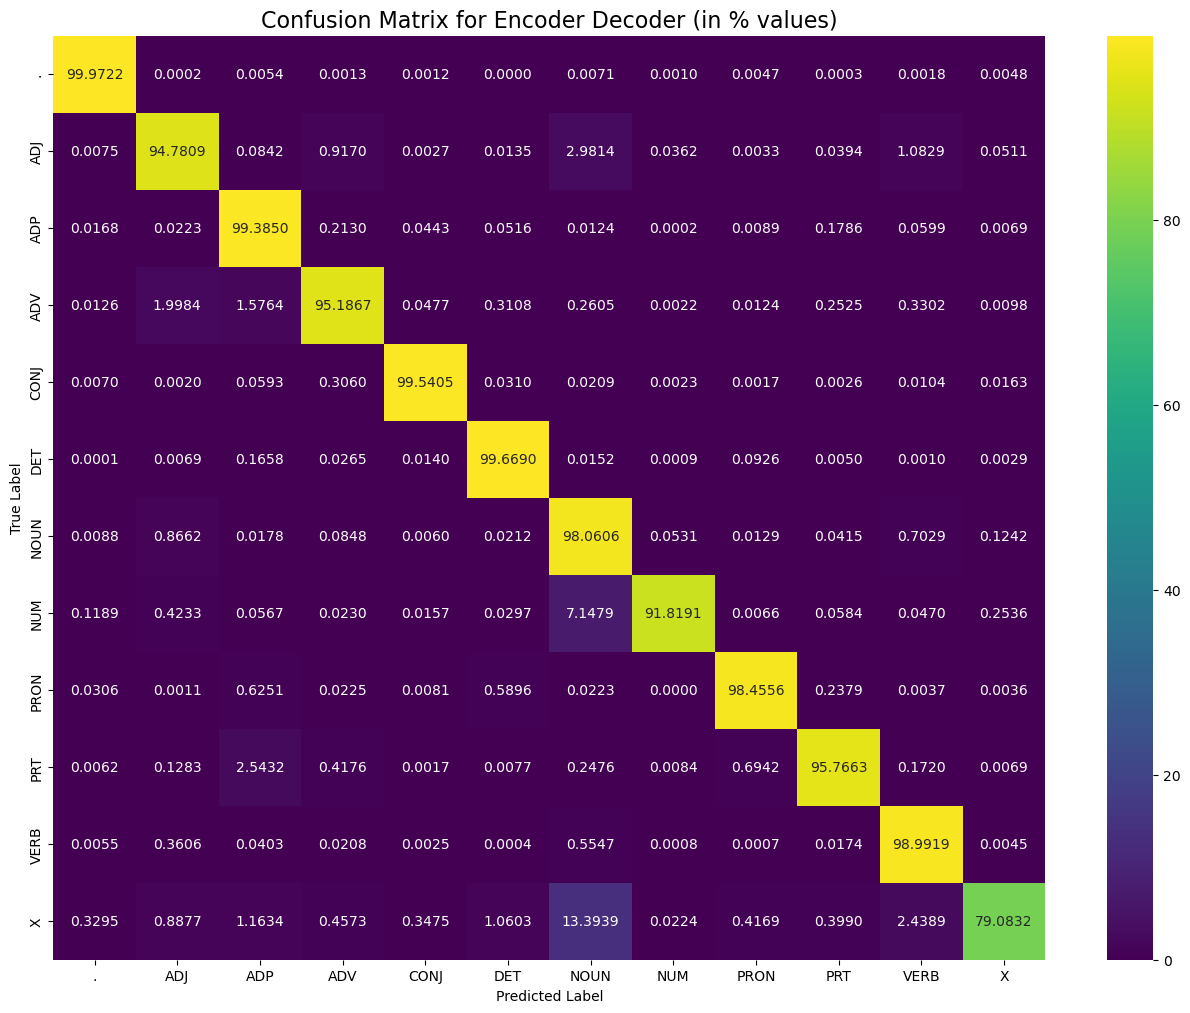

In [118]:
plot_confusion_matrix(enc_dec_run_dir, "Encoder Decoder")